# Getting Started with Azure Quantum Resource Estimation using Qiskit

👋 Welcome to the Azure Quantum Resource Estimator. In this notebook we will
guide you how to estimate and analyze the physical resource estimates of a
quantum program targeted for execution based on the architecture design of a
fault-tolerant quantum computer. As a running example we are using a multiplier.

## Implementing the algorithm

As a first step, we will create a sample application which will be used throughout this Resource Estimation notebook. To start, we'll import some Python packages from `azure.quantum` and `qiskit`.

In [1]:
# These are the Python imports that we use in this Qiskit-based example

from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RGQFTMultiplier
import numpy as np
from aquapointer.digital.ansatz import QAOA_ansatz

In [2]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.density_canvas.Lattice import Lattice
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.primitives import BackendSampler
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

def get_qubo_coeffs(canvas):
    estimated_variance = 30
    estimated_amplitude = 10

    # canvas.set_poisson_disk_lattice(spacing=(5, 5))
    canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)
    _ = canvas.calculate_pubo_coefficients(
            p = 2, #order of the PUBO, p=2 effectively creates a QUBO
            params = [estimated_amplitude, estimated_variance],
            efficient_qubo=True
        )
    qubo_coeffs = canvas._pubo

    return qubo_coeffs


# from the qubo coefficients dictionary, create a qubo matrix:
def get_random_qubo(size, seed):
    # define a canvas
    origin = (-20, -20)
    length = 40
    npoints = 80
    canvas = DensityCanvas(
        origin=origin,
        length_x=length,
        length_y=length,
        npoints_x=npoints,
        npoints_y=npoints,
    )
    # extract random centers with a minimal distance
    # and a padding from border
    n_centers = size #number of Gaussians
    min_dist = 1 #minimal distance between gaussians
    padding = 6 #minimal distance of Gaussian centers from border
    amplitude = 10 #amplitude of the Gaussians
    variance = 30 #variance of the Gaussians

    canvas.set_randomized_gaussian_density(
        n_centers = n_centers,
        amplitude = amplitude,
        variance = variance,
        minimal_distance = min_dist,
        padding = padding,
        seed=seed
    )
    # To see the result, call the draw method with draw_centers=True
    # canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

    qubo = get_qubo_coeffs(canvas)
    
    qubo_matrix = np.zeros((len(qubo['coeffs'][1]), len(qubo['coeffs'][1])))

    for key in qubo['coeffs'][1].keys():
        qubo_matrix[key[0]][key[0]] = qubo['coeffs'][1][key]

    for key in qubo['coeffs'][2].keys():
        qubo_matrix[key] = qubo['coeffs'][2][key]
        qubo_matrix[key[::-1]] = qubo['coeffs'][2][key]

    return qubo_matrix

qubo = np.array([[-0.02133358,  0.04727714,  0.04727714,  0.04727714,  0.04727714,
          0.03218907,  0.02656055,  0.01492186],
        [ 0.04727714, -0.01478681,  0.04727714,  0.03218907,  0.02656055,
          0.01492186,  0.01015968,  0.00470971],
        [ 0.04727714,  0.04727714, -0.01797982,  0.04727714,  0.03218907,
          0.02656055,  0.01492186,  0.01015968],
        [ 0.04727714,  0.03218907,  0.04727714, -0.02404681,  0.04727714,
          0.04727714,  0.03218907,  0.02656055],
        [ 0.04727714,  0.02656055,  0.03218907,  0.04727714, -0.02280619,
          0.04727714,  0.04727714,  0.03218907],
        [ 0.03218907,  0.01492186,  0.02656055,  0.04727714,  0.04727714,
         -0.02307382,  0.04727714,  0.04727714],
        [ 0.02656055,  0.01015968,  0.01492186,  0.03218907,  0.04727714,
          0.04727714, -0.01699135,  0.04727714],
        [ 0.01492186,  0.00470971,  0.01015968,  0.02656055,  0.03218907,
          0.04727714,  0.04727714, -0.0145127 ]])

qubo2 = np.array([[-0.01074377,  0.04727714,  0.04727714,  0.04727714],
        [ 0.04727714, -0.00892812,  0.03218907,  0.04727714],
        [ 0.04727714,  0.03218907, -0.00865155,  0.04727714],
        [ 0.04727714,  0.04727714,  0.04727714, -0.00969204]])


We are creating a quantum circuit for a multiplier based on the construction presented in [arXiv:1411.5949](https://arxiv.org/abs/1411.5949) which uses the Quantum Fourier Transform to implement arithmetic. You can adjust the size of the multiplier by changing the `bitwidth` variable. The circuit generation is wrapped in a function that can be called with the bitwidth of the multiplier. The circuit will have two input registers with that bitwidth, and one output register with the size of twice the bitwidth. The function will also print some logical resource counts for the multiplier extracted directly from the quantum circuit.

In [3]:
def create_algorithm(qubo, backend):

    qaoa_ansatz = QAOA_ansatz(qubo=qubo)

    beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
    gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
    params = np.array(beta+gamma)

    qaoa_ansatz.assign_parameters(parameters=params, inplace=True)

    circ = qaoa_ansatz

    # One could further reduce the resource estimates by increasing the optimization_level,
    # however, this will also increase the runtime to construct the algorithm.  Note, that
    # it does not affect the runtime for resource estimation.
    # print(f"[INFO] Decompose circuit into intrinsic quantum operations")

    # retrieve basis gates from backend
    basis_gates = backend.configuration().basis_gates
    circ = transpile(circ, basis_gates=basis_gates, optimization_level=0)
    
    # # print some statistics
    # print(f"[INFO]   qubit count: {circ.num_qubits}")
    # print("[INFO]   gate counts")
    # for gate, count in circ.count_ops().items():
    #     print(f"[INFO]   - {gate}: {count}")

    return circ


## Estimating the algorithm

Let's connect to the Azure Quantum workspace and create a backend instance for
the Azure Quantum Resource Estimator.  The backend acts as a target for our
quantum computing jobs.  Examples for other backends include QPUs to execute
quantum programs on today's quantum computers, or simulators to simulate the
functional behavior of a quantum program.  You can find examples for such
backends in other notebooks in the _Sample Gallery_.

In [4]:
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

workspace = Workspace(
            resource_id = "/subscriptions/2f90c9d6-c623-42f8-82f7-a36891f2a93f/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/wigners-friend2",
            location = "westeurope")


provider = AzureQuantumProvider(workspace)


In [5]:
backend = provider.get_backend('microsoft.estimator')


Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.


Next we will create an instance of our algorithm using the `create_algorithm` function. You can adjust the size of the multiplier by changing the `bitwidth` variable.

In [6]:
circ = create_algorithm(qubo2, backend)


Let's now estimate the physical resources for this circuit using the default assumptions. We can submit the circuit to the Resource Estimation backend using its `run` method.

In [7]:
job = backend.run(circ)
result = job.result()


.....

The simplest way to inspect the results of the job is to output them to the notebook. This will output a table with the overall physical resource counts. You can further inspect more details about the resource estimates by collapsing various groups which have more information. For example, if you collapse the *Logical qubit parameters* group, you can see that the quantum error correction (QEC) code distance is 15. In the last group you can see the physical qubit properties that were assumed for this estimation. For example, we see that the time to perform a single-qubit measurement and a single-qubit gate are assumed to be 100 ns and 50 ns, respectively.

In [8]:
result


Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 230 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.41M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 9.66e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,158.51k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 154,880 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,230,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,230,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 230. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,280,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 20 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,16,"Number of T factories capable of producing the demanded 280 T states during the algorithm's runtime The total number of T factories 16 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{280 \cdot 57,200\;\text{ns}}{1 \cdot 1,012,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,18,"Number of times all T factories are invoked In order to prepare the 280 T states, the 16 copies of the T factory are repeatedly invoked 18 times."
Physical algorithmic qubits,3.63k,"Number of physical qubits for the algorithm after layout The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


The total error budget sets the overall allowed error for the algorithm, i.e., the number of times it is allowed to fail. Its value must be between 0 and 1 and the default value is 0.001, which corresponds to 0.1%, and means that the algorithm is allowed to fail once in 1000 executions. This parameter is highly application specific. For example, if one is running Shor's algorithm for factoring integers, a large value for the error budget may be tolerated as one can check that the output are indeed the prime factors of the input. On the other hand, a much smaller error budget may be needed for an algorithm solving a problem with a solution which cannot be efficiently verified. This budget $\epsilon = \epsilon_{\log} + \epsilon_{\rm dis} + \epsilon_{\rm syn}$ is uniformly distributed and applies to errors $\epsilon_{\log}$ to implement logical qubits, an error budget $\epsilon_{\rm dis}$ to produce T states through distillation, and an error budget $\epsilon_{\rm syn}$ to synthesize rotation gates with arbitrary angles. Note that for distillation and rotation synthesis, the respective error budgets $\epsilon_{\rm dis}$ and $\epsilon_{\rm syn}$ are uniformly distributed among all T states and all rotation gates, respectively. If there are no rotation gates in the input algorithm, the error budget is uniformly distributed to logical errors and T state errors.


The code distance is the smallest odd integer greater or equal to $\dfrac{2\log(0.03 / 0.000000015360983102918585)}{\log(0.01/0.001)} - 1$ (Required logical qubit error rate in denominator)


The code distance is the smallest odd integer greater or equal to $\dfrac{2\log(0.03 / 0.0000000966183574879227)}{\log(0.01/0.001)} - 1$

Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits.

The logical qubit error rate is computed as $0.03 \cdot \left(\dfrac{0.001}{0.01}\right)^\frac{11 + 1}{2}$

The distribution of physical qubits used for the execution of the algorithm instructions and the supporting T factories can provide us valuable information to guide us in applying space and time optimizations. We can visualize this distribution to better understand the estimated space requirements for our algorithm.

In [9]:
result.data()['physicalCounts']

{'physicalQubits': 158510,
 'runtime': 1012000,
 'rqops': 3409091,
 'breakdown': {'algorithmicLogicalQubits': 15,
  'algorithmicLogicalDepth': 230,
  'logicalDepth': 230,
  'numTstates': 280,
  'clockFrequency': 227272.72727272726,
  'numTfactories': 16,
  'numTfactoryRuns': 18,
  'physicalQubitsForTfactories': 154880,
  'physicalQubitsForAlgorithm': 3630,
  'requiredLogicalQubitErrorRate': 9.66183574879227e-08,
  'requiredLogicalTstateErrorRate': 1.1904761904761904e-06,
  'numTsPerRotation': 14,
  'cliffordErrorRate': 0.001}}

In [10]:
import matplotlib.pyplot as plt
np.random.seed(42)

def get_depth(circ):
    depth = circ.depth()
    return depth
    
def get_runtime(circ):
    job = backend.run(circ)
    result = job.result()
    runtime = result.data()['physicalCounts']['runtime']
    qubit = result.data()['physicalCounts']['physicalQubits']
    return runtime, qubit


sizes = range(4, 50)
mean_qubits = []
std_qubits = []
mean_depths = []
std_depths = []
mean_runtimes = []
std_runtimes = []

num_trials = 5

for size in sizes:
    print(size)
    qubits = []
    depths = []
    runtimes = []
    for _ in range(num_trials):
        seed = np.random.randint(1,10000)
        qubo_matrix = get_random_qubo(size, seed)
        circ = create_algorithm(qubo_matrix, backend)
        depth = get_depth(circ)
        runtime, qubit = get_runtime(circ)
        
        qubits.append(qubit)
        depths.append(depth)
        runtimes.append(runtime)
    
    mean_qubits.append(np.mean(qubits))
    std_qubits.append(np.std(qubits))
    mean_depths.append(np.mean(depths))
    std_depths.append(np.std(depths))
    mean_runtimes.append(np.mean(runtimes))
    std_runtimes.append(np.std(runtimes))

# rescale to millisecs
mean_runtimes = np.array(mean_runtimes)
mean_runtimes = mean_runtimes/10**7 
std_runtimes = np.array(std_runtimes)
std_runtimes = std_runtimes/10**7




4
..........................5
..........................6
............................7
..........................8
...........................9
..........................10
.........................11
.........................12
............................13
..........................14
.............................15
.........................16
...........................17
..........................18
............................19
...........................20
..........................21
..........................22
...........................23
...........................24
............................25
...........................26
............................27
...........................28
............................29
...............................30
............................31
............................32
............................33
.............................34
.............................35
..............................36
..............................37
..

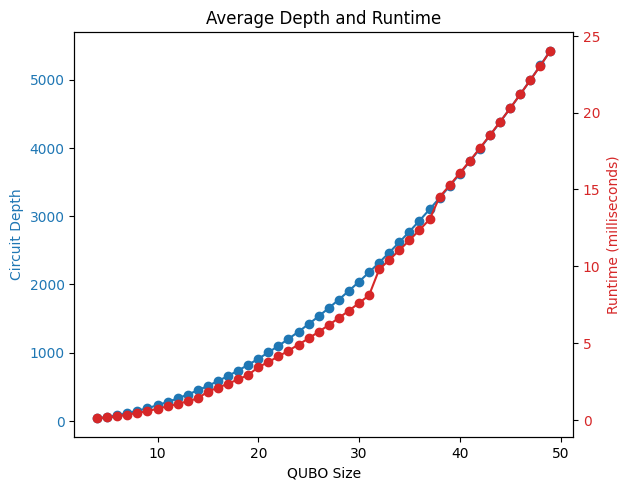

In [42]:
# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Circuit Depth', color=color)
ax1.errorbar(sizes, mean_depths, yerr=std_depths, fmt='-o', color=color, label='Depth')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Runtime (milliseconds)', color=color)
ax2.errorbar(sizes, mean_runtimes, yerr=std_runtimes, fmt='-o', color=color, label='Runtime')
ax2.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
# ax2.set_yscale('log')

fig.tight_layout()
plt.title('Average Depth and Runtime')
plt.show()

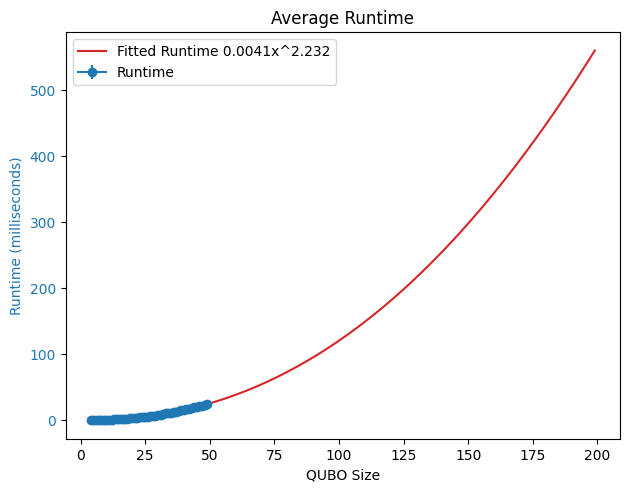

In [41]:
from scipy.optimize import curve_fit
def polynomial_model(x, a, b):
    return a * np.power(x, b)


# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(polynomial_model, list(sizes), mean_runtimes)
a, b = popt

# Generate fitted data for the polynomial model
sizes_fit = list(range(4, 200))
fitted_runtimes = polynomial_model(np.array(sizes_fit), a, b)

# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Runtime (milliseconds)', color=color)
ax1.errorbar(sizes, mean_runtimes, yerr=std_runtimes, fmt='-o', color=color, label='Runtime')
ax1.plot(sizes_fit, fitted_runtimes, color='tab:red', label=f'Fitted Runtime {round(a,4)}x^{round(b,4)}')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
plt.legend()

fig.tight_layout()
plt.title('Average Runtime')
plt.show()

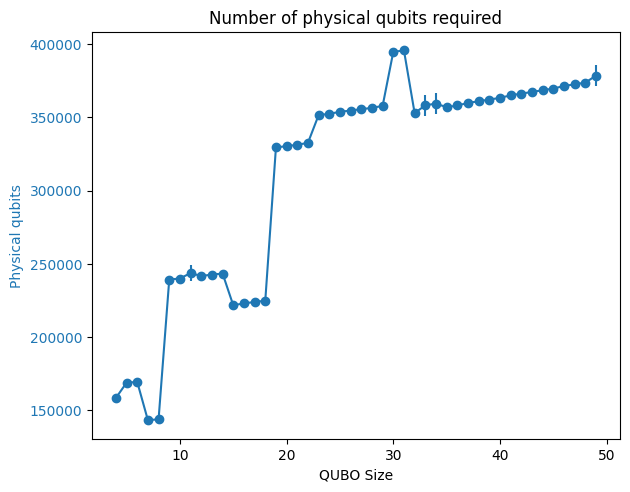

In [37]:
# Plotting the data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('QUBO Size')
ax1.set_ylabel('Physical qubits', color=color)
ax1.errorbar(sizes, mean_qubits, yerr=std_qubits, fmt='-o', color=color, label='Physical qubits')
ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')

fig.tight_layout()
plt.title('Number of physical qubits required')
plt.show()

In [39]:
pcov

array([[ 9.48901136e-08, -6.14640662e-06],
       [-6.14640662e-06,  3.99090187e-04]])

In [14]:
std_runtimes

array([0.00264   , 0.00021556, 0.00021556, 0.00025475, 0.000208  ,
       0.        , 0.00025475, 0.005616  , 0.000208  , 0.000208  ,
       0.        , 0.00029394, 0.        , 0.00024   , 0.00024   ,
       0.00024   , 0.00422564, 0.00024   , 0.00426633, 0.00029394,
       0.00954283, 0.00029394, 0.        , 0.00024   , 0.        ,
       0.        , 0.00092952, 0.        , 0.00050887, 0.01346743,
       0.01380651, 0.000272  , 0.        , 0.00033313, 0.        ,
       0.        , 0.000272  , 0.000272  , 0.000544  , 0.        ,
       0.00079301, 0.0009224 , 0.00033313, 0.000272  , 0.        ,
       0.017952  ])

In [15]:
mean_runtimes

array([ 0.10252 ,  0.158576,  0.223256,  0.349128,  0.450944,  0.5616  ,
        0.731432,  0.878488,  1.038024,  1.209624,  1.3988  ,  1.84356 ,
        2.0928  ,  2.35332 ,  2.63412 ,  2.92572 ,  3.4266  ,  3.76572 ,
        4.13088 ,  4.50324 ,  4.90392 ,  5.30664 ,  5.7354  ,  6.17592 ,
        6.6378  ,  7.1112  ,  7.6068  ,  8.1126  ,  9.793224, 10.411072,
       11.046872, 11.688656, 12.36172 , 13.048112, 14.50848 , 15.27144 ,
       16.060376, 16.862776, 17.691288, 18.53272 , 19.400944, 20.282768,
       21.189072, 22.109656, 23.05608 , 24.025216])

In [11]:
result.diagram.space


We can also visualize the time required to execute the algorithm as it relates to each T factory invocation runtime and the number of T factory invocations.

>
>  *You cannot visualize the time and space diagrams in the same cell.*
>

In [12]:
result.diagram.time


If you prefer a more compact version of the table, in which the descriptions are
provided by means of tooltips, you can write:

In [13]:
(1-3*10**(-8))**15

0.9999995500000939

In [14]:
result.summary


"This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 230 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory.Runtime",1 millisecs,Total runtime
"The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 9.66e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second.rQOPS",3.41M,Reliable quantum operations per second
"This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 154,880 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm.Physical qubits",158.51k,Number of physical qubits
"Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits.Logical algorithmic qubits",15,Number of logical qubits for the algorithm after layout
"To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation.Algorithmic depth",230,Number of logical cycles for the algorithm
"This number is usually equal to the logical depth of the algorithm, which is 230. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time.Logical depth",230,Number of logical cycles performed
This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.Clock frequency,227.27k,Number of logical cycles per second
"To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 20 single-qubit rotation gates with arbitrary angle rotation.Number of T states",280,Number of T states consumed by the algorithm
"The total number of T factories 16 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{280 \cdot 57,200\;\text{ns}}{1 \cdot 1,012,000\;\text{ns}}\right\rceil$Number of T factories",16,Number of T factories capable of producing the demanded 280 T states during the algorithm's runtime
"In order to prepare the 280 T states, the 16 copies of the T factory are repeatedly invoked 18 times.Number of T factory invocations",18,Number of times all T factories are invoked
"The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit.Physical algorithmic qubits",3.63k,Number of physical qubits for the algorithm after layout


We can also programmatically access all the values that can be passed to the job execution and see which default values were assumed:

In [15]:
result.data()["jobParams"]


{'qecScheme': {'name': 'surface_code',
  'errorCorrectionThreshold': 0.01,
  'crossingPrefactor': 0.03,
  'logicalCycleTime': '(4 * twoQubitGateTime + 2 * oneQubitMeasurementTime) * codeDistance',
  'physicalQubitsPerLogicalQubit': '2 * codeDistance * codeDistance',
  'maxCodeDistance': 50},
 'errorBudget': 0.001,
 'qubitParams': {'instructionSet': 'GateBased',
  'name': 'qubit_gate_ns_e3',
  'oneQubitMeasurementTime': '100 ns',
  'oneQubitGateTime': '50 ns',
  'twoQubitGateTime': '50 ns',
  'tGateTime': '50 ns',
  'oneQubitMeasurementErrorRate': 0.001,
  'oneQubitGateErrorRate': 0.001,
  'twoQubitGateErrorRate': 0.001,
  'tGateErrorRate': 0.001,
  'idleErrorRate': 0.001}}

We see that there are three input parameters that can be customized: `qubitParams`, `qecScheme`, and `errorBudget`.

### Qubit parameters

The first parameter `qubitParams` is used to specify qubit parameters.  When
modeling the physical qubit abstractions, we distinguish between two different
physical instruction sets that are used to operate the qubits.  The physical
instruction set can be either *gate-based* or *Majorana*.  A gate-based
instruction set provides single-qubit measurement, single-qubit gates (incl. T
 gates), and two-qubit gates.  A Majorana instruction set provides a physical T
 gate, single-qubit measurement and two-qubit joint measurement operations.

Qubit parameters can be completely customized.  Before we show this, we show hot
to choose from six pre-defined qubit parameters, four of which have gate-based
instruction sets and two with a Majorana instruction set.  An overview of all
pre-defined qubit parameters is provided by the following table:

| Pre-defined qubit parameters | Instruction set | References                                                                                                 |
|------------------------------|-----------------|------------------------------------------------------------------------------------------------------------|
| `"qubit_gate_ns_e3"`         | gate-based      | [arXiv:2003.00024](https://arxiv.org/abs/2003.00024), [arXiv:2111.11937](https://arxiv.org/abs/2111.11937) |
| `"qubit_gate_ns_e4"`         | gate-based      | [arXiv:2003.00024](https://arxiv.org/abs/2003.00024), [arXiv:2111.11937](https://arxiv.org/abs/2111.11937) |
| `"qubit_gate_us_e3"`         | gate-based      | [arXiv:1701.04195](https://arxiv.org/abs/1701.04195)                                                       |
| `"qubit_gate_us_e4"`         | gate-based      | [arXiv:1701.04195](https://arxiv.org/abs/1701.04195)                                                       |
| `"qubit_maj_ns_e4"`          | Majorana        | [arXiv:1610.05289](https://arxiv.org/abs/1610.05289)                                                       |
| `"qubit_maj_ns_e6"`          | Majorana        | [arXiv:1610.05289](https://arxiv.org/abs/1610.05289)                                                       |

Pre-defined qubit parameters can be selected by specifying the `name` field in
the `qubitParams`.  If no value is provided, `"qubit_gate_ns_e3"` is chosen as
the default qubit parameters.

Let's re-run resource estimation for our running example on the Majorana-based
qubit parameters `"qubit_maj_ns_e6"`.

In [16]:
job = backend.run(circ,
    qubitParams={
        "name": "qubit_maj_ns_e6"
    })
result = job.result()
result


.....

Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (6,000 nanosecs) multiplied by the 230 logical cycles to run the algorithm. If however the duration of a single T factory (here: 82,500 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,2.50M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 9.66e-8) multiplied by the clock frequency (166,666.67), which is the number of logical cycles per second."
Physical qubits,6.39k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 270 physical qubits to implement the algorithm logic, and 6,120 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,230,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,230,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 230. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,166.67k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 6 microsecs.
Number of T states,280,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 20 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,17,"Number of T factories capable of producing the demanded 280 T states during the algorithm's runtime The total number of T factories 17 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{280 \cdot 82,500\;\text{ns}}{1 \cdot 1,380,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,17,"Number of times all T factories are invoked In order to prepare the 280 T states, the 17 copies of the T factory are repeatedly invoked 17 times."
Physical algorithmic qubits,270,Number of physical qubits for the algorithm after layout The 270 are the product of the 15 logical qubits after layout and the 18 physical qubits that encode a single logical qubit.


Let's inspect the physical counts programmatically. For example, we can show all physical resource estimates and their breakdown using the `physicalCounts` field in the result data. This will show the logical qubit error and logical T-state error rates required to match the error budget. By default runtimes are shown in nanoseconds.

In [17]:
result.data()["physicalCounts"]


{'physicalQubits': 6390,
 'runtime': 1380000,
 'rqops': 2500000,
 'breakdown': {'algorithmicLogicalQubits': 15,
  'algorithmicLogicalDepth': 230,
  'logicalDepth': 230,
  'numTstates': 280,
  'clockFrequency': 166666.66666666666,
  'numTfactories': 17,
  'numTfactoryRuns': 17,
  'physicalQubitsForTfactories': 6120,
  'physicalQubitsForAlgorithm': 270,
  'requiredLogicalQubitErrorRate': 9.66183574879227e-08,
  'requiredLogicalTstateErrorRate': 1.1904761904761904e-06,
  'numTsPerRotation': 14,
  'cliffordErrorRate': 1e-06}}

We can also explore details about the T factory that was created to execute this algorithm.

In [18]:
result.data()["tfactory"]


{'physicalQubits': 360,
 'runtime': 82500,
 'numTstates': 1,
 'numInputTstates': 345,
 'numRounds': 2,
 'numUnitsPerRound': [23, 1],
 'unitNamePerRound': ['15-to-1 space efficient', '15-to-1 space efficient'],
 'codeDistancePerRound': [1, 3],
 'physicalQubitsPerRound': [276, 360],
 'runtimePerRound': [4500, 78000],
 'logicalErrorRate': 2.524470560905794e-07}

Next, we are using this data to produce some explanations of how the T factories produce the required T states.

In [19]:
data = result.data()
tfactory = data["tfactory"]
breakdown = data["physicalCounts"]["breakdown"]
producedTstates = breakdown["numTfactories"] * breakdown["numTfactoryRuns"] * tfactory["numTstates"]

print(f"""A single T factory produces {tfactory["logicalErrorRate"]:.2e} T states with an error rate of (required T state error rate is {breakdown["requiredLogicalTstateErrorRate"]:.2e}).""")
print(f"""{breakdown["numTfactories"]} copie(s) of a T factory are executed {breakdown["numTfactoryRuns"]} time(s) to produce {producedTstates} T states ({breakdown["numTstates"]} are required by the algorithm).""")
print(f"""A single T factory is composed of {tfactory["numRounds"]} rounds of distillation:""")
for round in range(tfactory["numRounds"]):
    print(f"""- {tfactory["numUnitsPerRound"][round]} {tfactory["unitNamePerRound"][round]} unit(s)""")


A single T factory produces 2.52e-07 T states with an error rate of (required T state error rate is 1.19e-06).
17 copie(s) of a T factory are executed 17 time(s) to produce 289 T states (280 are required by the algorithm).
A single T factory is composed of 2 rounds of distillation:
- 23 15-to-1 space efficient unit(s)
- 1 15-to-1 space efficient unit(s)


Custom qubit parameters must completely specify all required parameters.  These are the values that are
considered when the `instructionSet` is `"GateBased"`.

| Field (*required)               | Description                                                          |
|---------------------------------|----------------------------------------------------------------------|
| `name`                          | Some descriptive name for the parameters                             |
| `oneQubitMeasurementTime`*      | Operation time for single-qubit measurement ($t_{\rm meas}$) in ns   |
| `oneQubitGateTime`*             | Operation time for single-qubit Clifford gate ($t_{\rm gate}$) in ns |
| `twoQubitGateTime`              | Operation time for two-qubit Clifford gate in ns                     |
| `tGateTime`                     | Operation time for single-qubit non-Clifford gate in ns              |
| `oneQubitMeasurementErrorRate`* | Error rate for single-qubit measurement                              |
| `oneQubitGateErrorRate`*        | Error rate for single-qubit Clifford gate ($p$)                      |
| `twoQubitGateErrorRate`         | Error rate for two-qubit Clifford gate                               |
| `tGateErrorRate`                | Error rate to prepare single-qubit non-Clifford state ($p_T$)        |

The values for `twoQubitGateTime` and `tGateTime` default to `oneQubitGateTime`
when not specified; the values for `twoQubitGateErrorRate` and `tGateErrorRate`
default to `oneQubitGateErrorRate` when not specified.

A minimum template for qubit parameters based on a gate-based instruction set
with all required values is:

```json
{
    "qubitParams": {
        "instructionSet": "GateBased",
        "oneQubitMeasurementTime": <time string>,
        "oneQubitGateTime": <time string>,
        "oneQubitMeasurementErrorRate": <double>,
        "oneQubitGateErrorRate": <double>
    }
}
```

For time units, you need to specify time strings which are double-precision
floating point numbers followed by a space and a unit prefix which is `ns`, `µs`
(alternatively `us`), `ms`, or `s`.

These are the values that are considered when the `instructionSet` is
`"Majorana"`.

| Field (*required)                   | Description                                                         |
|-------------------------------------|---------------------------------------------------------------------|
| `name`                              | Some descriptive name for the parameters                            |
| `oneQubitMeasurementTime`*          | Operation time for single-qubit measurement ($t_{\rm meas}$) in ns  |
| `twoQubitJointMeasurementTime`      | Operation time for two-qubit joint measurement in ns                |
| `tGateTime`                         | Operation time for single-qubit non-Clifford gate in ns             |
| `oneQubitMeasurementErrorRate`*     | Error rate for single-qubit measurement                             |
| `twoQubitJointMeasurementErrorRate` | Error rate for two-qubit joint measurement                          |
| `tGateErrorRate`*                   | Error rate to prepare single-qubit non-Clifford state ($p_T$)       |

The values for `twoQubitJointMeasurementTime` and `tGateTime` default to
`oneQubitGateTime` when not specified; the value for
`twoQubitJointMeasurementErrorRate` defaults to `oneQubitMeasurementErrorRate`
when not specified.

A minimum template for qubit parameters based on a Majorana instruction set with
all required values is:

```json
{
    "qubitParams": {
        "instructionSet": "Majorana",
        "oneQubitMeasurementTime": <time string>,
        "oneQubitMeasurementErrorRate": <double>,
        "tGateErrorRate": <double>
    }
}
```

### QEC schemes

To execute practical-scale quantum applications, we require operations with very
low error rates. These error rate targets are typically beyond the capabilities
of raw physical qubits. To overcome this limitation, quantum error correction
(QEC) and fault-tolerant computation are two crucial techniques that form the
building blocks of large-scale quantum computers. First, QEC allows us to
compose multiple error-prone physical qubits and build a more reliable logical
qubit that preserves quantum information better than the underlying physical
qubits. Several QEC schemes have been developed since the last three decades,
including popular schemes such as the Shor-code, surface code, color codes and
others, and recently the [Hastings-Haah code](https://arxiv.org/abs/2107.02194).
These schemes vary based on the number of physical qubits they require, the
connectivity among qubits and other factors. By using QEC techniques, we can
achieve a fault-tolerant quantum computation, enabling reliable storing and
processing of quantum information in the presence of noise. To store information
reliably, we require that the QEC scheme is able to suppress errors when the
physical qubits meet a certain threshold error rate. To process information, we
require fault-tolerant operations that allow applications to perform general
purpose quantum computations efficiently and limit the spread of errors that
occur while computing with logical qubits. Schemes for fault-tolerant operations
include techniques such as lattice surgery and transversal operations. Together,
QEC and fault-tolerance techniques bridges the accuracy gap between quantum
hardware and algorithms.

The error correction code distance (or just code distance in short) is a
parameter that controls the number of errors that can be corrected, and thus the
error rate of the logical qubits and the number of physical qubits required to
encode them.  The higher the code distance, the better the accuracy, but also
the higher the amount of physical qubits.  The goal is to find the minimum code
distance that can achieve the required error rate set for a particular
application.  We will explain later in this notebook how a global error budget
is provided as input and how it is distributed throughout the estimation,
including the logical error rate of logical qubits.

We follow the standard way of modeling logical error rates using an exponential
model parameterized by the code distance $d$, physical error rate $p$, QEC
threshold $p^*$.  The physical error rate $p$ is extracted from the qubit
parameters above as the worst-case error rate any physical Clifford operation in
the device.  In particular, we set $p = {}$ `max(oneQubitMeasurementErrorRate,
oneQubitGateErrorRate, twoQubitGateErrorRate)` for qubit parameters with a
gate-based instruction set, and $p = {}$ `max(oneQubitMeasurementErrorRate,
twoQubitJointMeasurementErrorRate)` for qubit parameters with a Majorana
instruction set.  QEC schemes typically have a error rate threshold $p^*$ below
which error correction suppresses errors.

Our current implementation uses the formula

$$
P = a\left(\frac{p}{p^*}\right)^{\frac{d+1}{2}}
$$

as the generic model.  The exact parameters for each pre-defined QEC scheme
(including  a crossing pre-factor $a$ which can be extracted numerically for
simulations) are listed below.

In Azure Quantum Resource Estimation we can abstract the quantum error
correction scheme based on the above formula by providing values for the
crossing pre-factor $a$ and the error correction threshold $p^*$.  Further, one
needs to specify the logical cycle time, i.e., the time to execute a single
logical operation, which depends on the code distance and the  physical
operation time assumptions of the underlying physical qubits.  Finally, a second
formula computes the number of physical qubits required to encode one logical
qubit based on the code distance.

As with the physical qubit parameters, one can choose from several pre-defined
QEC schemes, can extend pre-defined ones, and can provide custom schemes by
providing all parameters.  Note that QEC schemes are tightly connected to the
physical instruction set of the physical qubit parameters, and therefore are
defined specifically for one of the two instruction sets.

We provide three pre-defined QEC schemes, two `"surface_code"` protocols for
gate-based and Majorana physical instruction sets, and the `"floquet_code"`
protocol that is so far only implemented for a Majorana physical instruction set
in the resource estimator.

| QEC scheme     | Instruction set | References                                                                                                 |
|----------------|-----------------|------------------------------------------------------------------------------------------------------------|
| `surface_code` | gate-based      | [arXiv:1208.0928](https://arxiv.org/abs/1208.0928), [arXiv:1009.3686](https://arxiv.org/abs/1009.3686)     |
| `surface_code` | Majorana        | [arXiv:1909.03002](https://arxiv.org/abs/1909.03002), [arXiv:2007.00307](https://arxiv.org/abs/2007.00307) |
| `floquet_code` | Majorana        | [arXiv:2202.11829](https://arxiv.org/abs/2202.11829)                                                       |

In case of `"surface_code"` the corresponding scheme is selected based on the
qubit type of the physical qubit parameters.  The gate-based surface code is
based on [[arXiv:1208.0928](https://arxiv.org/abs/1208.0928)] and
[[arXiv:1009.3686](https://arxiv.org/abs/1009.3686)]. The surface code for
Majorana qubits is based on
[[arXiv:1909.03002](https://arxiv.org/abs/1909.03002)] and
[[arXiv:2007.00307](https://arxiv.org/abs/2007.00307)] (replacing 8 steps to
measure a single stabilizer in the former reference by 20 steps to measure all
stabilizers). The floquet code, which can only be selected for Majorana qubits,
is based on [[arXiv:2202.11829](https://arxiv.org/abs/2202.11829)].

Pre-defined qubit parameters can be selected by specifying the `name` field in
the `qecScheme` parameter.  If no value is provided, `"surface_code"` is used as
default value.

Let's re-run resource estimation for our running example on the Majorana-based
qubit parameters with a Floquet code.

In [20]:
job = backend.run(circ,
    qubitParams={
        "name": "qubit_maj_ns_e6"
    },
    qecScheme={
        "name": "floquet_code"
    })
result_maj_floquet = job.result()
result_maj_floquet


........

Runtime,207 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (900 nanosecs) multiplied by the 230 logical cycles to run the algorithm. If however the duration of a single T factory (here: 14,100 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,16.67M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 9.66e-8) multiplied by the clock frequency (1,111,111.11), which is the number of logical cycles per second."
Physical qubits,21.58k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 780 physical qubits to implement the algorithm logic, and 20,800 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,230,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,230,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 230. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,1.11M,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 901 nanosecs.
Number of T states,280,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 20 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,20,"Number of T factories capable of producing the demanded 280 T states during the algorithm's runtime The total number of T factories 20 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{280 \cdot 14,100\;\text{ns}}{1 \cdot 207,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,14,"Number of times all T factories are invoked In order to prepare the 280 T states, the 20 copies of the T factory are repeatedly invoked 14 times."
Physical algorithmic qubits,780,Number of physical qubits for the algorithm after layout The 780 are the product of the 15 logical qubits after layout and the 52 physical qubits that encode a single logical qubit.


To specify a QEC scheme the user has to specify 2 values, the
`errorCorrectionThreshold` and the `crossingPrefactor`, as well as 2 formulas
for the `logicalCycleTime`, and the `physicalQubitsPerLogicalQubit`.  A template
for QEC schemes is as follows:

```json
{
    "qecScheme": {
        "crossingPrefactor": <double>,
        "errorCorrectionThreshold": <double>,
        "logicalCycleTime": <formula string>,
        "physicalQubitsPerLogicalQubit": <formula string>
    }
}
```

Inside the formulas, the user can make use of the following variables

* `oneQubitGateTime`
* `twoQubitGateTime`
* `oneQubitMeasurementTime`
* `twoQubitJointMeasurementTime`

whose value is taken from the corresponding field from the physical qubit
parameters (note that some variables are not available based on the qubit
parameters' instruction set), as well as the variable

* `codeDistance`

for the code distance computed for the logical qubit, based on the physical
qubit properties, the error correction threshold, and the crossing prefactor.
The time variables and `codeDistance` can be used to describe the
`logicalCycleTime` formula.  For the formula `physicalQubitsPerLogicalQubit`
only the `codeDistance` can be used.

### Error budget

The third parameter `errorBudget` models the total error budget $\epsilon$.  It
sets the overall allowed error for the algorithm, i.e., the number of times it
is allowed to fail.  Its value must be between 0 and 1 and the default value is
0.001, which corresponds to 0.1%, and means that the algorithm is allowed to
fail once in 1000 executions.  This parameter is highly application specific.
For example, if one is running Shor's algorithm for factoring integers, a large
value for the error budget may be tolerated as one can check that the output are
indeed the prime factors of the input.  On the other hand, a much smaller error
budget may be needed for an algorithm solving a problem with a solution which
cannot be efficiently verified.  This budget

$$
  \epsilon = \epsilon_{\log} + \epsilon_{\rm dis} + \epsilon_{\rm syn}
$$

is uniformly distributed and applies to errors $\epsilon_{\log}$ to implement
logical qubits, an error budget $\epsilon_{\rm dis}$ to produce T states through
distillation, and an error budget $\epsilon_{\rm syn}$ to synthesize rotation
gates with arbitrary angles.  Note that for distillation and rotation synthesis,
the respective error budgets $\epsilon_{\rm dis}$ and $\epsilon_{\rm syn}$ are
uniformly distributed among all required T states and all required rotation
gates, respectively. If there are no rotation gates in the input algorithm, the
error budget is uniformly distributed to logical errors and T state errors.

Next, we re-run the last experiment with a an error budget of 10%.

In [21]:
job = backend.run(circ,
    qubitParams={
        "name": "qubit_maj_ns_e6"
    },
    qecScheme={
        "name": "floquet_code"
    },
    errorBudget=0.1)
result_maj_floquet_e1 = job.result()
result_maj_floquet_e1


.....

Runtime,56 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (300 nanosecs) multiplied by the 185 logical cycles to run the algorithm. If however the duration of a single T factory (here: 4,500 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,50.00M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 1.20e-5) multiplied by the clock frequency (3,333,333.33), which is the number of logical cycles per second."
Physical qubits,708,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 60 physical qubits to implement the algorithm logic, and 648 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,185,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 20 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 11 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,185,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 185. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,3.33M,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 301 nanosecs.
Number of T states,220,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 11 for each of the 20 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,18,"Number of T factories capable of producing the demanded 220 T states during the algorithm's runtime The total number of T factories 18 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{220 \cdot 4,500\;\text{ns}}{1 \cdot 55,500\;\text{ns}}\right\rceil$"
Number of T factory invocations,13,"Number of times all T factories are invoked In order to prepare the 220 T states, the 18 copies of the T factory are repeatedly invoked 13 times."
Physical algorithmic qubits,60,Number of physical qubits for the algorithm after layout The 60 are the product of the 15 logical qubits after layout and the 4 physical qubits that encode a single logical qubit.


## Next steps

We hope you enjoyed this notebook and found it helpful in exploring the physical resource estimates for quantum programs. Here are some suggested next steps:

* Try estimating the resources for a different Qiskit program.
* Explore how qubit parameters and QEC schemes affect the error correction code distance of the logical qubit.
* Visualize your and compare your results from different parameter sets with the space and time diagrams.
* Use the output data to derive logical qubit properties.
* Learn how to setup complex resource estimation experiments in the _Advanced analysis of estimates_ notebook.